In [1]:
!gcloud auth application-default login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login&state=PYjzZ33YmaLzlOzUUqxJBk3QvyA8Ob&access_type=offline&code_challenge=wGyML1Tyg7dGJRPELXPcyszHAeLWOS26D1RsFi_YJiw&code_challenge_method=S256


Credentials saved to file: [/Users/yt4/.config/gcloud/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "open-targets-genetics-dev" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the project owning the resource.


In [2]:
!gcloud auth login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=a9tl4VmrHV9nLVTY3Yx0VlUqhREaiz&access_type=offline&code_challenge=T0eCaa2a8xmuaGAEnK5SlfJTmfqSdw7WlgKs_Y0MP2w&code_challenge_method=S256


You are now logged in as [yt4@sanger.ac.uk].
Your current project is [open-targets-genetics-dev].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


In [1]:
import os

import hail as hl
import numpy as np
import pyspark.sql.functions as f
from pyspark.sql import DataFrame

from gentropy.common.session import Session
from gentropy.dataset.study_index import StudyIndex
from gentropy.dataset.summary_statistics import SummaryStatistics
from gentropy.dataset.study_locus import StudyLocus
from gentropy.susie_finemapper import SusieFineMapperStep
from gentropy.method.drug_enrichment_from_evid import chemblDrugEnrichment

Loading BokehJS ...

In [2]:
"""Common utilities for the project."""

import os
from pathlib import Path
from gentropy.common.session import Session
import logging


def get_gcs_credentials() -> str:
    """Get the credentials for google cloud storage."""
    app_default_credentials = os.path.join(
        os.getenv("HOME", "."), ".config/gcloud/application_default_credentials.json"
    )

    service_account_credentials = os.path.join(
        os.getenv("HOME", "."), ".config/gcloud/service_account_credentials.json"
    )

    if Path(app_default_credentials).exists():
        return app_default_credentials
    else:
        raise FileNotFoundError("No GCS credentials found.")


def get_gcs_hadoop_connector_jar() -> str:
    """Get the google cloud storage hadoop connector for spark.

    This function will return the url to download the hadoop jar.
    """

    return (
        "https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar"
    )


def gcs_conf(
    credentials_path=None, project="open-targets-genetics-dev"
) -> dict[str, str]:
    """Get the spark configuration with hadoop connector for google cloud storage."""
    credentials_path = credentials_path or get_gcs_credentials()
    return {
        "spark.driver.memory": "12g",
        "spark.kryoserializer.buffer.max": "500m",
        "spark.driver.maxResultSize":"2g",
        "spark.hadoop.fs.gs.impl": "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem",
        "spark.jars": get_gcs_hadoop_connector_jar(),
        "spark.hadoop.google.cloud.auth.service.account.enable": "true",
        "spark.hadoop.fs.gs.project.id": project,
        "spark.hadoop.google.cloud.auth.service.account.json.keyfile": credentials_path,
        "spark.hadoop.fs.gs.requester.pays.mode": "AUTO",
    }


class GentropySession(Session):
    def __init__(self, *args, **kwargs):
        if "extended_spark_conf" in kwargs:
            kwargs["extended_spark_conf"].update(gcs_conf())
        else:
            kwargs["extended_spark_conf"] = gcs_conf()
        super().__init__(*args, **kwargs)

    @property
    def conf(self):
        logging.warning(
            "To change the config restart the session and use the `extended_spark_conf` parameter."
        )
        return self.spark.sparkContext.getConf().getAll()

session= GentropySession()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/23 10:55:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/23 10:56:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
path_to_release_folder="gs://open-targets-data-releases/25.06/"
#path_to_release_folder="gs://open-targets-pre-data-releases/24.12-uo_test-3/output/genetics/parquet/"
#path_to_release_folder="gs://ot_orchestration/releases/25.02_freeze1/"

In [4]:
si=StudyIndex.from_parquet(session,path_to_release_folder+"output/study/")
sl=StudyLocus.from_parquet(session,path_to_release_folder+"output/credible_set/")

# Table 1: studies and credible sets

In [5]:
si=StudyIndex.from_parquet(session,path_to_release_folder+"output/study/")

In [6]:
si.df.count()

1966178

In [7]:
si.df.groupBy("studyType").count().show()

+---------+-------+
|studyType|  count|
+---------+-------+
|     gwas| 100526|
|     sqtl| 213952|
|     pqtl|   3756|
|    tuqtl| 364199|
|     eqtl|1233664|
|   sceqtl|  50081|
+---------+-------+



In [8]:
si.df.groupBy("qualityControls").count().show(100,truncate=False)

+-----------------------------------------------------------------+-------+
|qualityControls                                                  |count  |
+-----------------------------------------------------------------+-------+
|[]                                                               |1907130|
|[The number of SNPs in the study is below the expected threshold]|2313   |
|[Harmonized summary statistics are not available or empty]       |56735  |
+-----------------------------------------------------------------+-------+



In [9]:
si.df.groupBy("projectId").count().show(100,truncate=False)

+---------------------+-------+
|projectId            |count  |
+---------------------+-------+
|Bossini-Castillo_2019|12432  |
|FINNGEN_R12          |2303   |
|Jerber_2021          |4869   |
|Fairfax_2014         |16007  |
|CEDAR                |14213  |
|ROSMAP               |35089  |
|Nathan_2022          |10542  |
|Braineac2            |3307   |
|Sun_2018             |802    |
|Walker_2019          |10575  |
|HipSci               |25745  |
|van_de_Bunt_2015     |5280   |
|Nedelec_2016         |22950  |
|BrainSeq             |36105  |
|Aygun_2021           |6554   |
|Kasela_2017          |3194   |
|BLUEPRINT            |59832  |
|GEUVADIS             |26867  |
|OneK1K               |14364  |
|TwinsUK              |68304  |
|UKB_PPP_EUR          |2954   |
|Alasoo_2018          |24550  |
|Kim-Hellmuth_2017    |5254   |
|GTEx                 |1070093|
|FUSION               |64652  |
|Schmiedel_2018       |74879  |
|Young_2019           |1793   |
|Steinberg_2020       |7678   |
|Fairfax

In [10]:
sl=StudyLocus.from_parquet(session,path_to_release_folder+"output/credible_set/")

In [11]:
sl.df.count()

2833758

In [12]:
df=sl.df
df = df.withColumn("csSize", f.size(f.col("locus")))
df.count()

2833758

In [13]:
df.filter(f.col("studyType")=="gwas").select("studyId").distinct().count()

39282

In [14]:
df.show(1)

25/06/23 10:56:58 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+---------+---------------+----------+--------+------+------------+-------+------+--------------+--------------+-------------------------------+-------------+-------------------+--------------------+-----------------+----------------+------------------+------------+-----------+----------+--------+----------+--------------------+--------------------+--------------------+----------+------+
|        studyLocusId|studyType|      variantId|chromosome|position|region|     studyId|   beta|zScore|pValueMantissa|pValueExponent|effectAlleleFrequencyFromSource|standardError|subStudyDescription|     qualityControls|finemappingMethod|credibleSetIndex|credibleSetlog10BF|purityMeanR2|purityMinR2|locusStart|locusEnd|sampleSize|               ldSet|               locus|          confidence|isTransQtl|csSize|
+--------------------+---------+---------------+----------+--------+------+------------+-------+------+--------------+--------------+-------------------------------+-----------

In [60]:
def stats_from_list(list_of_studies_to_eval):
    filtered_df = df.join(list_of_studies_to_eval, on="studyId", how="inner")

    filtered_df_one_cs=filtered_df.select("region").distinct()
    print(f"Number of regions: {filtered_df_one_cs.count()}")

    filtered_df_one_cs=filtered_df.select("studyId").distinct()
    print(f"Number of studies with at leaset one CS: {filtered_df_one_cs.count()}")

    si_filtered_df_one_cs=si.df.join(filtered_df_one_cs, on="studyId", how="inner").cache()
    n_binary=si_filtered_df_one_cs.filter(f.col("nCases")>0).count()/si_filtered_df_one_cs.count()
    print(f"% of binary traits: {n_binary}")

    print(f"number of pubmedids: {si_filtered_df_one_cs.select('pubmedId').distinct().count()}")

    df_exploded = si_filtered_df_one_cs.select("studyId","ldPopulationStructure").withColumn("ldPop", f.explode("ldPopulationStructure"))
    eur=df_exploded.filter((f.col("ldPop.ldPopulation")=="nfe") & (f.col("ldPop.relativeSampleSize")>=0.9)).select("studyId").distinct().count()
    noneur=(si_filtered_df_one_cs.count()-eur)/si_filtered_df_one_cs.count()
    print(f"% of non-european ancestry samples: {noneur}")

    efos=si_filtered_df_one_cs.select("diseaseIds").distinct().count()
    print(f"N unique EFOs: {efos}")

    geneid=si_filtered_df_one_cs.select("geneId").distinct().count()
    print(f"N unique geneIds: {geneid}")

    biosampleid=si_filtered_df_one_cs.select("biosampleId").distinct().count()
    print(f"N unique biosampleIds: {biosampleid}")

    mean_median_df = si_filtered_df_one_cs.agg(
        f.mean("nSamples").alias("mean_nSamples"),
        f.expr('percentile_approx(nSamples, 0.5)').alias("median_nSamples")
    )

    mean_median_df.show()

    print(f"Number of CSs: {filtered_df.count()}")

    mean_median_df = filtered_df.agg(
        f.mean("csSize").alias("mean_csSize"),
        f.expr('percentile_approx(csSize, 0.5)').alias("median_csSize")
    )
    mean_median_df.show()


    filtered_with_condition = filtered_df.filter(
        f.expr("exists(locus, x -> x.posteriorProbability >= 0.9)")
    )

    print(f"% of CSs that has SNP PIP>=0.9: {filtered_with_condition.count()/filtered_df.count()}")


## Curated associatons

In [26]:
curated_assoc = si.df.filter(f.array_contains(f.col("qualityControls"), "Harmonized summary statistics are not available or empty")).cache()

curated_assoc.count()

list_of_studies_to_eval=curated_assoc

25/06/23 12:28:44 WARN CacheManager: Asked to cache already cached data.


In [27]:
stats_from_list(list_of_studies_to_eval)

Number of regions: 1


25/06/23 12:28:57 WARN CacheManager: Asked to cache already cached data.        


Number of studies with at leaset one CS: 18191
% of binary traits: 0.2190094002528723
% of non-european ancestry samples: 0.2781045571986147


N unique EFOs: 7047
N unique geneIds: 1
N unique biosampleIds: 1
+-----------------+---------------+
|    mean_nSamples|median_nSamples|
+-----------------+---------------+
|83790.04292252735|          10708|
+-----------------+---------------+



Number of CSs: 153568


+------------------+-------------+
|       mean_csSize|median_csSize|
+------------------+-------------+
|36.182049645759534|           13|
+------------------+-------------+



% of CSs that has SNP PIP>=0.9: 0.20524458220462596


## GWAS Catalog SS

In [28]:
filtered_studies = si.df.filter((f.col("studyId").startswith("GCS")) & (f.col("studyType")=="gwas"))
gcss = filtered_studies.filter(~f.array_contains(f.col("qualityControls"), "Harmonized summary statistics are not available or empty")).cache()
gcss.count()

25/06/23 12:31:14 WARN CacheManager: Asked to cache already cached data.


41488

In [29]:
stats_from_list(gcss)

Number of regions: 198912


25/06/23 12:31:26 WARN CacheManager: Asked to cache already cached data.        


Number of studies with at leaset one CS: 19849
% of binary traits: 0.13718575243085293
% of non-european ancestry samples: 0.3152299863972996


N unique EFOs: 3698


N unique geneIds: 1
N unique biosampleIds: 1
+------------------+---------------+
|     mean_nSamples|median_nSamples|
+------------------+---------------+
|101969.30711874654|          21081|
+------------------+---------------+



Number of CSs: 615181


+-----------------+-------------+
|      mean_csSize|median_csSize|
+-----------------+-------------+
|20.81895409643666|            3|
+-----------------+-------------+



% of CSs that has SNP PIP>=0.9: 0.4010055577139086


## FinnGen

In [20]:
orig_study_index=StudyIndex.from_parquet(session,"gs://finngen_data/r12/study_index")

In [21]:
orig_study_index.df.count()

2470

In [22]:
orig_study_index.df.show(1)

+--------------------+-----------+---------+---------------+------------------------+----------+------+---------------------+-----------+--------+----------------+----------------------+---------------+------------------+----------------------------------+--------------------+--------------------+------+---------+--------+---------+---------------------+-------------------+------------------+---------------+-------------+--------------------+-----------+---------+---------------+
|             studyId|  projectId|studyType|traitFromSource|traitFromSourceMappedIds|diseaseIds|geneId|biosampleFromSourceId|biosampleId|pubmedId|publicationTitle|publicationFirstAuthor|publicationDate|publicationJournal|backgroundTraitFromSourceMappedIds|backgroundDiseaseIds|   initialSampleSize|nCases|nControls|nSamples|  cohorts|ldPopulationStructure|   discoverySamples|replicationSamples|qualityControls|analysisFlags|summarystatsLocation|hasSumstats|condition|sumstatQCValues|
+--------------------+--------

In [30]:
filtered_studies = si.df.filter(f.col("projectId")=="FINNGEN_R12").cache()
filtered_studies.count()

25/06/23 12:33:31 WARN CacheManager: Asked to cache already cached data.


2303

In [31]:
stats_from_list(filtered_studies)

Number of regions: 10521


25/06/23 12:33:45 WARN CacheManager: Asked to cache already cached data.        


Number of studies with at leaset one CS: 1242
% of binary traits: 1.0
% of non-european ancestry samples: 1.0
N unique EFOs: 974
N unique geneIds: 1
N unique biosampleIds: 1
+------------------+---------------+
|     mean_nSamples|median_nSamples|
+------------------+---------------+
|423135.87520128826|         467756|
+------------------+---------------+



Number of CSs: 20704


+-----------------+-------------+
|      mean_csSize|median_csSize|
+-----------------+-------------+
|51.45508114374034|           14|
+-----------------+-------------+



% of CSs that has SNP PIP>=0.9: 0.13519126738794435


## UKBB-PPP


In [32]:
orig_study_index=StudyIndex.from_parquet(session,"gs://ukb_ppp_eur_data/study_index")

In [33]:
orig_study_index.df.count()

2957

In [34]:
orig_study_index.df.show(1)

+--------------------+-----------+---------+--------------------+------------------------+----------+---------------+---------------------+-----------+--------+----------------+----------------------+---------------+------------------+----------------------------------+--------------------+-----------------+------+---------+--------+-------+---------------------+-------------------+------------------+---------------+-------------+--------------------+-----------+---------+---------------+
|             studyId|  projectId|studyType|     traitFromSource|traitFromSourceMappedIds|diseaseIds|         geneId|biosampleFromSourceId|biosampleId|pubmedId|publicationTitle|publicationFirstAuthor|publicationDate|publicationJournal|backgroundTraitFromSourceMappedIds|backgroundDiseaseIds|initialSampleSize|nCases|nControls|nSamples|cohorts|ldPopulationStructure|   discoverySamples|replicationSamples|qualityControls|analysisFlags|summarystatsLocation|hasSumstats|condition|sumstatQCValues|
+-----------

In [35]:
filtered_studies = si.df.filter(f.col("projectId")=="UKB_PPP_EUR").cache()
filtered_studies.count()

2954

In [36]:
stats_from_list(filtered_studies)

Number of regions: 12113


Number of studies with at leaset one CS: 2375


% of binary traits: 0.0
% of non-european ancestry samples: 0.0
N unique EFOs: 1


N unique geneIds: 2358
N unique biosampleIds: 1
+-----------------+---------------+
|    mean_nSamples|median_nSamples|
+-----------------+---------------+
|33482.18063157895|          33657|
+-----------------+---------------+



Number of CSs: 32150


+------------------+-------------+
|       mean_csSize|median_csSize|
+------------------+-------------+
|12.716982892690513|            2|
+------------------+-------------+



% of CSs that has SNP PIP>=0.9: 0.42889580093312596


## eQTL Catalogue



In [43]:
orig_study_index=StudyIndex.from_parquet(session,"gs://eqtl_catalogue_data/study_index")

In [44]:
orig_study_index.df.groupBy("studyType").count().show()

+---------+-------+
|studyType|  count|
+---------+-------+
|     sqtl| 214987|
|     pqtl|    802|
|    tuqtl| 364493|
|     eqtl|1248635|
|   sceqtl|  50675|
+---------+-------+



### eQTL

In [45]:
filtered_studies = orig_study_index.df.filter(f.col("studyType")=="eqtl").cache()
filtered_studies.count()

1248635

In [46]:
stats_from_list(filtered_studies)

Number of regions: 185918


Number of studies with at leaset one CS: 1210140


% of binary traits: 0.0


% of non-european ancestry samples: 1.0


N unique EFOs: 1


N unique geneIds: 28175


N unique biosampleIds: 77


+----------------+---------------+
|   mean_nSamples|median_nSamples|
+----------------+---------------+
|329.133953096336|            318|
+----------------+---------------+



Number of CSs: 1349478


+------------------+-------------+
|       mean_csSize|median_csSize|
+------------------+-------------+
|24.735926039550108|            9|
+------------------+-------------+



% of CSs that has SNP PIP>=0.9: 0.17478462042360082


### pQTL

In [47]:
filtered_studies = orig_study_index.df.filter(f.col("studyType")=="pqtl").cache()
filtered_studies.count()

802

In [48]:
stats_from_list(filtered_studies)

Number of regions: 735


Number of studies with at leaset one CS: 789


% of binary traits: 0.0
% of non-european ancestry samples: 1.0
N unique EFOs: 1


N unique geneIds: 735
N unique biosampleIds: 1
+-------------+---------------+
|mean_nSamples|median_nSamples|
+-------------+---------------+
|       3301.0|           3301|
+-------------+---------------+



Number of CSs: 1581


+------------------+-------------+
|       mean_csSize|median_csSize|
+------------------+-------------+
|14.939911448450347|            4|
+------------------+-------------+



% of CSs that has SNP PIP>=0.9: 0.26818469323213157


### tuqtl

In [49]:
filtered_studies = orig_study_index.df.filter(f.col("studyType")=="tuqtl").cache()
filtered_studies.count()

364493

In [50]:
stats_from_list(filtered_studies)

Number of regions: 12480


Number of studies with at leaset one CS: 353260


% of binary traits: 0.0
% of non-european ancestry samples: 1.0


N unique EFOs: 1


N unique geneIds: 12486


N unique biosampleIds: 74
+------------------+---------------+
|     mean_nSamples|median_nSamples|
+------------------+---------------+
|345.70696937100155|            324|
+------------------+---------------+



Number of CSs: 384852


+-----------------+-------------+
|      mean_csSize|median_csSize|
+-----------------+-------------+
|22.17207913691497|            9|
+-----------------+-------------+



% of CSs that has SNP PIP>=0.9: 0.18475413925353124


### sQTL

In [51]:
filtered_studies = orig_study_index.df.filter(f.col("studyType")=="sqtl").cache()
filtered_studies.count()

214987

In [52]:
stats_from_list(filtered_studies)

Number of regions: 32895


Number of studies with at leaset one CS: 209582


% of binary traits: 0.0
% of non-european ancestry samples: 1.0
N unique EFOs: 1


N unique geneIds: 13301


N unique biosampleIds: 74
+----------------+---------------+
|   mean_nSamples|median_nSamples|
+----------------+---------------+
|356.395029153267|            324|
+----------------+---------------+



Number of CSs: 223500


+------------------+-------------+
|       mean_csSize|median_csSize|
+------------------+-------------+
|21.606331096196868|            9|
+------------------+-------------+



% of CSs that has SNP PIP>=0.9: 0.18253691275167785


### sc-eQTL

In [53]:
filtered_studies = orig_study_index.df.filter(f.col("studyType")=="sceqtl").cache()
filtered_studies.count()

50675

In [54]:
stats_from_list(filtered_studies)

Number of regions: 7687


Number of studies with at leaset one CS: 48723


% of binary traits: 0.0
% of non-european ancestry samples: 1.0
N unique EFOs: 1


N unique geneIds: 7123


N unique biosampleIds: 29
+------------------+---------------+
|     mean_nSamples|median_nSamples|
+------------------+---------------+
|392.22847525809163|            194|
+------------------+---------------+



Number of CSs: 52744


+------------------+-------------+
|       mean_csSize|median_csSize|
+------------------+-------------+
|60.795066737448806|           21|
+------------------+-------------+



% of CSs that has SNP PIP>=0.9: 0.06869027756711664


## GWAS only

In [61]:
filtered_studies = si.df.filter(f.col("studyType")=="gwas").cache()
filtered_studies.count()

25/06/23 16:31:04 WARN CacheManager: Asked to cache already cached data.


100526

In [62]:
stats_from_list(filtered_studies)

Number of regions: 209433


25/06/23 16:31:18 WARN CacheManager: Asked to cache already cached data.        


Number of studies with at leaset one CS: 39282
% of binary traits: 0.20235731378239397


number of pubmedids: 4250
% of non-european ancestry samples: 0.31968840690392547


N unique EFOs: 9280
N unique geneIds: 1
N unique biosampleIds: 1
+------------------+---------------+
|     mean_nSamples|median_nSamples|
+------------------+---------------+
|103845.61599200143|          11272|
+------------------+---------------+



Number of CSs: 789453


+------------------+-------------+
|       mean_csSize|median_csSize|
+------------------+-------------+
|24.610909072484365|            5|
+------------------+-------------+



% of CSs that has SNP PIP>=0.9: 0.35595405932968777


In [63]:
filtered_df = df.join(filtered_studies.select("studyId"), on="studyId", how="inner")
filtered_df_one_cs=filtered_df.select("studyId").distinct()
si_filtered_df_one_cs=si.df.join(filtered_df_one_cs, on="studyId", how="inner").cache()
si_filtered_df_one_cs.count()

39282

In [64]:
si_filtered_df_one_cs.show(1)

+--------------------+-----------+---------+--------------------+------------------------+-------------+------+---------------------+-----------+--------+----------------+----------------------+---------------+------------------+----------------------------------+--------------------+--------------------+------+---------+--------+---------+---------------------+-------------------+------------------+---------------+-------------+--------------------+-----------+---------+---------------+
|             studyId|  projectId|studyType|     traitFromSource|traitFromSourceMappedIds|   diseaseIds|geneId|biosampleFromSourceId|biosampleId|pubmedId|publicationTitle|publicationFirstAuthor|publicationDate|publicationJournal|backgroundTraitFromSourceMappedIds|backgroundDiseaseIds|   initialSampleSize|nCases|nControls|nSamples|  cohorts|ldPopulationStructure|   discoverySamples|replicationSamples|qualityControls|analysisFlags|summarystatsLocation|hasSumstats|condition|sumstatQCValues|
+-------------

In [ ]:
si_filtered_df_one_cs.dropna(subset=["publicationDate"]).orderBy("publicationDate").limit(1).show()

+----------+---------+---------+---------------+------------------------+-------------+------+---------------------+-----------+--------+--------------------+----------------------+---------------+------------------+----------------------------------+--------------------+--------------------+------+---------+--------+-------+---------------------+-----------------+------------------+--------------------+-------------+--------------------+-----------+---------+---------------+
|   studyId|projectId|studyType|traitFromSource|traitFromSourceMappedIds|   diseaseIds|geneId|biosampleFromSourceId|biosampleId|pubmedId|    publicationTitle|publicationFirstAuthor|publicationDate|publicationJournal|backgroundTraitFromSourceMappedIds|backgroundDiseaseIds|   initialSampleSize|nCases|nControls|nSamples|cohorts|ldPopulationStructure| discoverySamples|replicationSamples|     qualityControls|analysisFlags|summarystatsLocation|hasSumstats|condition|sumstatQCValues|
+----------+---------+---------+------

25/06/24 04:57:10 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 916970 ms exceeds timeout 120000 ms
25/06/24 04:57:10 WARN SparkContext: Killing executors is not supported by current scheduler.
25/06/24 04:57:19 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

## non-GWAS only

In [57]:
filtered_studies = si.df.filter(f.col("studyType")!="gwas").cache()
filtered_studies.count()

1865652

In [58]:
stats_from_list(filtered_studies)

Number of regions: 232364


Number of studies with at leaset one CS: 1824869


% of binary traits: 0.0
% of non-european ancestry samples: 0.9986985367168821
N unique EFOs: 1


N unique geneIds: 29342


N unique biosampleIds: 98


+------------------+---------------+
|     mean_nSamples|median_nSamples|
+------------------+---------------+
|381.59002372225075|            322|
+------------------+---------------+



Number of CSs: 2044305


+-----------------+-------------+
|      mean_csSize|median_csSize|
+-----------------+-------------+
|24.64486365782014|            9|
+-----------------+-------------+



% of CSs that has SNP PIP>=0.9: 0.17884024154908393


# Varaint index

In [33]:
vi=session.spark.read.parquet(path_to_release_folder+"output/variant")

In [34]:
vi.count()

6493882

25/03/18 01:38:41 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 922657 ms exceeds timeout 120000 ms
25/03/18 01:38:41 WARN SparkContext: Killing executors is not supported by current scheduler.
25/03/18 01:53:51 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [30]:
vi.printSchema()

root
 |-- variantId: string (nullable = true)
 |-- chromosome: string (nullable = true)
 |-- position: integer (nullable = true)
 |-- referenceAllele: string (nullable = true)
 |-- alternateAllele: string (nullable = true)
 |-- variantEffect: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- method: string (nullable = true)
 |    |    |-- assessment: string (nullable = true)
 |    |    |-- score: float (nullable = true)
 |    |    |-- assessmentFlag: string (nullable = true)
 |    |    |-- targetId: string (nullable = true)
 |    |    |-- normalisedScore: double (nullable = true)
 |-- mostSevereConsequenceId: string (nullable = true)
 |-- transcriptConsequences: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- variantFunctionalConsequenceIds: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- aminoAcidChange: string (nullable = true)
 |    |    |-- uniprotAccessions:

In [95]:
vi.filter(f.col("transcriptConsequences").isNull()).count()

0

In [96]:
vi.show(5, truncate=False)

+---------------+----------+--------+---------------+---------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [42]:
vi.dropDuplicates(["variantId"]).count()

6229644

# Feature matrix

In [7]:
fm=session.spark.read.parquet(path_to_release_folder+"intermediate/l2g_feature_matrix/")

In [8]:
fm.count()

26410395

In [9]:
fm.select("studyLocusId").distinct().count()

577450

In [12]:
fm.printSchema()

root
 |-- studyLocusId: string (nullable = true)
 |-- geneId: string (nullable = true)
 |-- credibleSetConfidence: float (nullable = true)
 |-- distanceFootprintMean: float (nullable = true)
 |-- distanceFootprintMeanNeighbourhood: float (nullable = true)
 |-- distanceSentinelFootprint: float (nullable = true)
 |-- distanceSentinelFootprintNeighbourhood: float (nullable = true)
 |-- distanceSentinelTss: float (nullable = true)
 |-- distanceSentinelTssNeighbourhood: float (nullable = true)
 |-- distanceTssMean: float (nullable = true)
 |-- distanceTssMeanNeighbourhood: float (nullable = true)
 |-- eQtlColocClppMaximum: float (nullable = true)
 |-- eQtlColocClppMaximumNeighbourhood: float (nullable = true)
 |-- eQtlColocH4Maximum: float (nullable = true)
 |-- eQtlColocH4MaximumNeighbourhood: float (nullable = true)
 |-- geneCount500kb: double (nullable = true)
 |-- isProteinCoding: float (nullable = true)
 |-- pQtlColocClppMaximum: float (nullable = true)
 |-- pQtlColocClppMaximumNeighbo

In [12]:
fm=fm.filter(f.col("isProteinCoding")==1).cache()
fm.count()

7734143

In [14]:
fm.select("studyLocusId").distinct().count()

567803

In [12]:
gene_count_per_studyLocusId = fm.groupBy("studyLocusId").agg(
    f.countDistinct("geneId").alias("geneId_count")
)

In [13]:
# Calculate mean and median of geneId_count
mean_median = gene_count_per_studyLocusId.agg(
    f.mean("geneId_count").alias("mean_geneId_count"),
    f.expr("percentile_approx(geneId_count, 0.5)").alias("median_geneId_count")
)

# Show the result
mean_median.show()

+------------------+-------------------+
| mean_geneId_count|median_geneId_count|
+------------------+-------------------+
|13.621173188588296|                 10|
+------------------+-------------------+



In [14]:
distance=fm.filter(
    (f.col("distanceSentinelFootprintNeighbourhood")==1) |
    (f.col("distanceSentinelTssNeighbourhood")==1))

In [15]:
distance.count()

675574

In [15]:
coloc_thr=0.8
clpp_thr=0.01

In [17]:
molQTL=fm.filter(
    (f.col("eQtlColocClppMaximum")>=clpp_thr) | 
    (f.col("eQtlColocH4Maximum")>=coloc_thr))
molQTL.count()

501850

In [18]:
molQTL=fm.filter(
    (f.col("pQtlColocClppMaximum")>=clpp_thr) | 
    (f.col("pQtlColocH4Maximum")>=coloc_thr))
molQTL.count()

49940

In [19]:
molQTL=fm.filter(
    (f.col("sQtlColocClppMaximum")>=clpp_thr) | 
    (f.col("sQtlColocH4Maximum")>=coloc_thr))
molQTL.count()

279788

In [20]:
vepQTL=fm.filter(
    (f.col("vepMaximum")>=0.66))
vepQTL.count()

100404

In [10]:
# combinig it with l2g predictions
l2g=session.spark.read.parquet(path_to_release_folder+"output/l2g_prediction")

In [16]:
combined_df = fm.join(l2g.drop("features","shapBaseValue"), on=["geneId", "studyLocusId"], how="left").fillna(0).cache()
combined_df.count()

25/04/28 22:01:06 WARN CacheManager: Asked to cache already cached data.


7734143

In [17]:
combined_df = combined_df.withColumn(
    "l2g_05",
    f.when(f.col("score") >= 0.05, 1).otherwise(0)
)
combined_df = combined_df.withColumn(
    "eQTL_coloc",
    f.when(
    (f.col("eQtlColocClppMaximum")>=clpp_thr) | 
    (f.col("eQtlColocH4Maximum")>=coloc_thr), 1).otherwise(0)
)
combined_df = combined_df.withColumn(
    "pQTL_coloc",
    f.when(
    (f.col("pQtlColocClppMaximum")>=clpp_thr) | 
    (f.col("pQtlColocH4Maximum")>=coloc_thr), 1).otherwise(0)
)
combined_df = combined_df.withColumn(
    "sQTL_coloc",
    f.when(
    (f.col("sQtlColocClppMaximum")>=clpp_thr) | 
    (f.col("sQtlColocH4Maximum")>=coloc_thr), 1).otherwise(0)
)
combined_df = combined_df.withColumn(
    "VEP",
    f.when((f.col("vepMaximum")>=0.66), 1).otherwise(0)
)
combined_df = combined_df.withColumn(
    "distance",
    f.when((f.col("distanceSentinelFootprintNeighbourhood")==1) |
    (f.col("distanceSentinelTssNeighbourhood")==1), 1).otherwise(0)
)

In [20]:
combined_df.show(1)

+---------------+--------------------+---------------------+---------------------+----------------------------------+-------------------------+--------------------------------------+-------------------+--------------------------------+---------------+----------------------------+--------------------+---------------------------------+------------------+-------------------------------+--------------+---------------+--------------------+---------------------------------+------------------+-------------------------------+---------------------+--------------------+---------------------------------+------------------+-------------------------------+----------+-----------------------+-------+--------------------+-----+------+----------+----------+----------+---+--------+
|         geneId|        studyLocusId|credibleSetConfidence|distanceFootprintMean|distanceFootprintMeanNeighbourhood|distanceSentinelFootprint|distanceSentinelFootprintNeighbourhood|distanceSentinelTss|distanceSentinelTssNeig

In [ ]:
#combined_df.repartition(1).write.csv("./data/feature_matrix_l2g.csv",mode="overwrite",header=True)

In [25]:
combined_df = combined_df.select(
    "l2g_05", 
    "eQTL_coloc", 
    "pQTL_coloc", 
    "sQTL_coloc", 
    "VEP", 
    "distance"
).cache()

# Count the rows to trigger the cache
combined_df.count()

7734143

In [26]:
combined_df.show()

+------+----------+----------+----------+---+--------+
|l2g_05|eQTL_coloc|pQTL_coloc|sQTL_coloc|VEP|distance|
+------+----------+----------+----------+---+--------+
|     0|         0|         0|         0|  0|       0|
|     0|         0|         0|         0|  0|       0|
|     0|         0|         0|         0|  0|       0|
|     0|         0|         0|         0|  0|       0|
|     0|         0|         0|         0|  0|       0|
|     0|         0|         0|         0|  0|       0|
|     0|         0|         0|         0|  0|       0|
|     1|         1|         0|         1|  1|       1|
|     1|         1|         0|         1|  1|       1|
|     1|         1|         0|         1|  1|       1|
|     1|         0|         0|         0|  0|       1|
|     1|         0|         0|         0|  0|       1|
|     0|         0|         0|         0|  0|       0|
|     0|         0|         0|         0|  0|       0|
|     0|         0|         0|         0|  0|       0|
|     0|  

In [27]:
from pyspark.sql import functions as f

# Define the columns to compare with l2g_05
columns_to_compare = ["eQTL_coloc", "pQTL_coloc", "sQTL_coloc", "VEP", "distance"]

# Initialize an empty list to store the results
results = []

# Loop through each column and calculate overlaps
for col in columns_to_compare:
    # Calculate counts
    counts = combined_df.filter(
        (f.col("l2g_05") == 1) | (f.col(col) == 1)  # Ignore rows where both are 0
    ).agg(
        f.sum(f.when((f.col("l2g_05") == 1) & (f.col(col) == 1), 1).otherwise(0)).alias("overlap"),
        f.sum(f.when((f.col("l2g_05") == 1) & (f.col(col) == 0), 1).otherwise(0)).alias("l2g_05_only"),
        f.sum(f.when((f.col("l2g_05") == 0) & (f.col(col) == 1), 1).otherwise(0)).alias(f"{col}_only")
    ).collect()[0]

    # Extract counts and append to results
    results.append({
        "column": col,
        "overlap": counts["overlap"],
        "l2g_05_only": counts["l2g_05_only"],
        "col_only": counts[f"{col}_only"]
    })

In [28]:
results

[{'column': 'eQTL_coloc',
  'overlap': 364940,
  'l2g_05_only': 627127,
  'col_only': 136910},
 {'column': 'pQTL_coloc',
  'overlap': 49745,
  'l2g_05_only': 942322,
  'col_only': 195},
 {'column': 'sQTL_coloc',
  'overlap': 250383,
  'l2g_05_only': 741684,
  'col_only': 29405},
 {'column': 'VEP', 'overlap': 95083, 'l2g_05_only': 896984, 'col_only': 5321},
 {'column': 'distance',
  'overlap': 655252,
  'l2g_05_only': 336815,
  'col_only': 20322}]

In [29]:
session.spark.createDataFrame(results).show()

+--------+----------+-----------+-------+
|col_only|    column|l2g_05_only|overlap|
+--------+----------+-----------+-------+
|  136910|eQTL_coloc|     627127| 364940|
|     195|pQTL_coloc|     942322|  49745|
|   29405|sQTL_coloc|     741684| 250383|
|    5321|       VEP|     896984|  95083|
|   20322|  distance|     336815| 655252|
+--------+----------+-----------+-------+



# L2G predictions

In [21]:
l2g=session.spark.read.parquet(path_to_release_folder+"output/l2g_prediction")

In [33]:
#l2g=session.spark.read.parquet("gs://ot-team/irene/l2g/06032025/locus_to_gene_best_model/predictions")

In [22]:
l2g.printSchema()

root
 |-- studyLocusId: string (nullable = true)
 |-- geneId: string (nullable = true)
 |-- score: double (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- value: float (nullable = true)
 |    |    |-- shapValue: float (nullable = true)
 |-- shapBaseValue: float (nullable = true)



In [23]:
l2g.count()

992067

In [24]:
l2g.show(1,truncate=False)

+--------------------------------+---------------+------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [25]:
l2g.select("studyLocusId").distinct().count()

567252

In [26]:
l2g.filter(f.col("score")>=0.5).count()

437338

In [27]:
l2g.filter(f.col("score")>=0.5).select("studyLocusId").distinct().count()

411362

In [40]:
#l2g.filter(f.col("studyLocusId")=="0b1384451666f2d7e94f6697d6502b3b").show(100,truncate=False)

In [41]:
filtered_l2g=l2g

filtered_df = filtered_l2g.filter(f.col("score") >= 0.5).select("studyLocusId")

# Step 2: Group by studyLocusId and count occurrences
grouped_df = filtered_df.groupBy("studyLocusId").count()

grouped_df=grouped_df.withColumnRenamed("count","count_studyLocusId")
# Step 3: Aggregate the counts
result_df = grouped_df.groupBy("count_studyLocusId").count().cache()
# Show the results
#result_df.show(truncate=False)

# Calculate the number of instances
only_once = result_df.filter(f.col("count_studyLocusId") == 1).select(f.sum("count")).collect()[0][0]
twice = result_df.filter(f.col("count_studyLocusId") == 2).select(f.sum("count")).collect()[0][0]
more_than_twice = result_df.filter(f.col("count_studyLocusId") > 2).select(f.sum("count")).collect()[0][0]

# Print the results
print(f"Number of studyLocusId met only once: {only_once}")
print(f"Number of studyLocusId met twice: {twice}")
print(f"Number of studyLocusId met more than twice: {more_than_twice}")

Number of studyLocusId met only once: 387658
Number of studyLocusId met twice: 21728
Number of studyLocusId met more than twice: 1976


In [42]:
filtered_l2g=l2g
filtered_df = filtered_l2g.filter(f.col("score") >= 0.5).select("studyLocusId")
count_df = filtered_df.groupBy("studyLocusId").count()

# Show the result
count_df=count_df.filter(f.col("count")>1).cache()
count_df.count()

23704

In [43]:
#count_df.show(1)

In [44]:
#fm=session.spark.read.parquet("gs://open-targets-pre-data-releases/2503-testrun-1/output/l2g_feature_matrix")

In [45]:
#fm=fm.filter(f.col("isProteinCoding")==1).cache()

In [46]:
#fm.count()

In [47]:
#fm.repartition(1).write.csv("gs://genetics-portal-dev-analysis/yt4/20241024_EGL_playground/20250303_fm_all_rows.csv",header=True,mode="overwrite",sep="\t")

In [50]:
#l2g_priv.drop("locusToGeneFeatures").repartition(1).write.csv("gs://genetics-portal-dev-analysis/yt4/20241024_EGL_playground/24_12_l2g.csv",header=True,mode="overwrite",sep="\t")

In [51]:
path_to_release_folder_priv="gs://open-targets-pre-data-releases/24.12-uo_test-3/output/genetics/parquet/"
l2g_priv=session.spark.read.parquet(path_to_release_folder_priv+"l2g_predictions")
l2g_priv.count()

filtered_l2g=l2g_priv

filtered_df = filtered_l2g.filter(f.col("score") >= 0.5).select("studyLocusId")

# Step 2: Group by studyLocusId and count occurrences
grouped_df = filtered_df.groupBy("studyLocusId").count()

grouped_df=grouped_df.withColumnRenamed("count","count_studyLocusId")
# Step 3: Aggregate the counts
result_df = grouped_df.groupBy("count_studyLocusId").count().cache()
# Show the results
#result_df.show(truncate=False)

# Calculate the number of instances
only_once = result_df.filter(f.col("count_studyLocusId") == 1).select(f.sum("count")).collect()[0][0]
twice = result_df.filter(f.col("count_studyLocusId") == 2).select(f.sum("count")).collect()[0][0]
more_than_twice = result_df.filter(f.col("count_studyLocusId") > 2).select(f.sum("count")).collect()[0][0]

# Print the results
print(f"Number of studyLocusId met only once: {only_once}")
print(f"Number of studyLocusId met twice: {twice}")
print(f"Number of studyLocusId met more than twice: {more_than_twice}")

Number of studyLocusId met only once: 340903
Number of studyLocusId met twice: 16288
Number of studyLocusId met more than twice: 1175


In [52]:
# Perform an inner join on the studyLocusId column
joined_df = l2g.drop("features","shapBaseValue").join(l2g_priv.drop("locusToGeneFeatures").withColumnRenamed("score","score_priv"), on=["studyLocusId","geneId"], how="inner").cache()

joined_df.count()

666803

In [53]:
# Show the result
joined_df.show(1,truncate=False)

+--------------------------------+---------------+------------------+------------------+
|studyLocusId                    |geneId         |score             |score_priv        |
+--------------------------------+---------------+------------------+------------------+
|00117f0551bb5139ebd76f0a4fa2aca0|ENSG00000077616|0.8804187506122791|0.8128893925911914|
+--------------------------------+---------------+------------------+------------------+
only showing top 1 row



In [54]:
# Calculate the correlation between score and priv_score
correlation = joined_df.corr("score", "score_priv")

# Show the correlation
print(f"Correlation between score and priv_score: {correlation}")

Correlation between score and priv_score: 0.812420799313093


In [55]:
from pyspark.sql import functions as f

# Calculate the 2x2 contingency table
contingency_table = joined_df.agg(
    f.sum(f.when((f.col("score") > 0.5) & (f.col("score_priv") > 0.5), 1).otherwise(0)).alias("both_above_0_5"),
    f.sum(f.when((f.col("score") > 0.5) & (f.col("score_priv") <= 0.5), 1).otherwise(0)).alias("score_above_0_5_only"),
    f.sum(f.when((f.col("score") <= 0.5) & (f.col("score_priv") > 0.5), 1).otherwise(0)).alias("priv_score_above_0_5_only"),
    f.sum(f.when((f.col("score") <= 0.5) & (f.col("score_priv") <= 0.5), 1).otherwise(0)).alias("both_below_or_equal_0_5")
).collect()[0]

# Print the contingency table
print(f"Both score and priv_score > 0.5: {contingency_table['both_above_0_5']}")
print(f"Only score > 0.5: {contingency_table['score_above_0_5_only']}")
print(f"Only priv_score > 0.5: {contingency_table['priv_score_above_0_5_only']}")
print(f"Both score and priv_score <= 0.5: {contingency_table['both_below_or_equal_0_5']}")

Both score and priv_score > 0.5: 289904
Only score > 0.5: 43294
Only priv_score > 0.5: 57835
Both score and priv_score <= 0.5: 275770


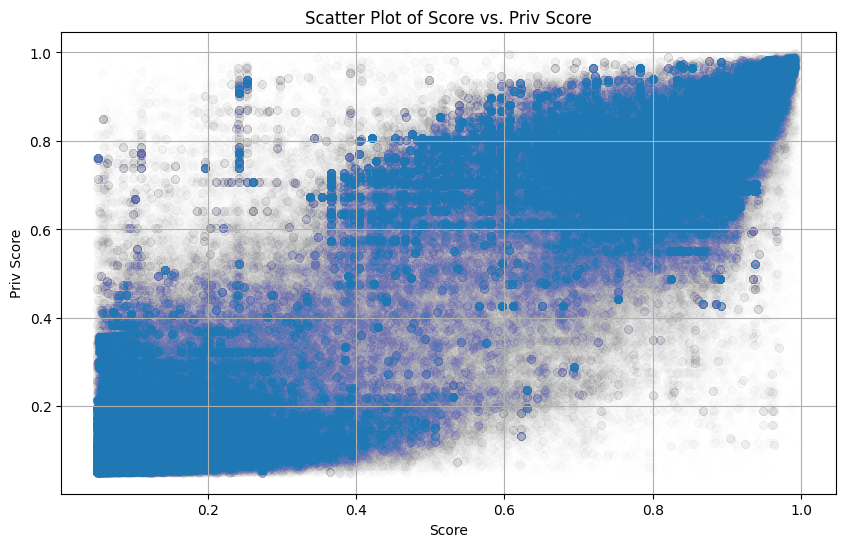

25/03/07 20:08:59 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1047029 ms exceeds timeout 120000 ms
25/03/07 20:08:59 WARN SparkContext: Killing executors is not supported by current scheduler.
25/03/07 20:24:22 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Collect the data into a Pandas DataFrame
pandas_df = joined_df.select("score", "score_priv").toPandas()

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df["score"], pandas_df["score_priv"], alpha=0.005)
plt.title("Scatter Plot of Score vs. Priv Score")
plt.xlabel("Score")
plt.ylabel("Priv Score")
plt.grid(True)
plt.show()